#### Import modules & prepare data

In [1]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from os import walk
from time import sleep
from IPython.display import clear_output
%matplotlib inline

# Data source: https://www.kaggle.com/stephenmugisha/particle-collisions

_, _, files = next(walk('data'))

target_names = {
    '0': 'electron',    # Negatively charged particle that is a lepton  (doesn't take part in strong force).
    '1': 'muon',    # Electron with 200 times more mass and makes up lots of cosmic radiation.
    '2': 'pion',    # Meson (connects with strong force) that can be positive, negative, or neutral
    '3': 'kaon',    # Pion with more mass.
    '4': 'proton'    # Positively charged particle with 2 up quarks and 1 down quark.
}

# Check how the data is formatted/stored.
file_test = open(f'data/{files[0]}', 'rb')
file = pickle.load(file_test)

print(file[0].shape)    # Group of 3000 images.
print(file[0][0].shape)    # Check first image.
print(file[1].shape)    # Group of 3000 targets.
print(file[1][0])    # Classified as 'pion.'

# Collect all the data.
data = []
target = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file =  pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data.append(sample)
        target.append(sample_target)

data = np.array(data)
target = np.array(target)

sleep(7)
clear_output()

print(f'original data.shape: {data.shape}')
print(f'original target.shape: {target.shape}\n')

# Edit target values to 0, 1, 2...
new_target = []

for tar in target:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target = np.array(new_target)

for i in range(5):
    particle_indexes = np.where(target == i)[0]

    data_modified = data[particle_indexes]
    target_modified = target[particle_indexes]
    
    print(f'{target_names[str(i)]}.shape: {data_modified.shape}, {target_modified.shape}')

# NOTE: through the above code, we find there are inconsistencies in the data (less samples for one particle but lots of samples in another)


original data.shape: (1259300, 10, 10)
original target.shape: (1259300,)

electron.shape: (3150, 10, 10), (3150,)
muon.shape: (700, 10, 10), (700,)
pion.shape: (981050, 10, 10), (981050,)
kaon.shape: (160300, 10, 10), (160300,)
proton.shape: (114100, 10, 10), (114100,)


#### Reshaping data (to make even)

In [2]:
muon_indexes = np.where(target == 1)[0]    # since this has least # of samples... use this as limiter

def set_data_samples(number_of_samples):    # limit to <= 700 samples for each particle. (to keep data even)
    
    data_new, target_new = ((data[muon_indexes])[:number_of_samples], (target[muon_indexes])[:number_of_samples])
    
    for i in [0, 2, 3, 4]:
        particle_indexes = np.where(target == i)[0]
        data_modified = (data[particle_indexes])[:number_of_samples]    
        target_modified = (target[particle_indexes])[:number_of_samples]
    
        data_new = np.append(data_new, data_modified, axis=0)
        target_new = np.append(target_new, target_modified)

    return (np.array(data_new), np.array(target_new))


data_50_samples, target_50_samples = set_data_samples(50)
data_100_samples, target_100_samples = set_data_samples(100)
data_150_samples, target_150_samples = set_data_samples(150)
data_200_samples, target_200_samples = set_data_samples(200)
data_250_samples, target_250_samples = set_data_samples(250)
data_300_samples, target_300_samples = set_data_samples(300)
data_350_samples, target_350_samples = set_data_samples(350)
data_400_samples, target_400_samples = set_data_samples(400)
data_450_samples, target_450_samples = set_data_samples(450)
data_500_samples, target_500_samples = set_data_samples(500)
data_550_samples, target_550_samples = set_data_samples(550)
data_600_samples, target_600_samples = set_data_samples(600)
data_650_samples, target_650_samples = set_data_samples(650)
data_700_samples, target_700_samples = set_data_samples(700)


# data_140_samples, target_140_samples = set_data_samples(140)    # NOTE: These will be used for later tests.
# data_280_samples, target_280_samples = set_data_samples(280)
# data_420_samples, target_420_samples = set_data_samples(420)
# data_560_samples, target_560_samples = set_data_samples(560)
# data_700_samples, target_700_samples = set_data_samples(700)

data = data_700_samples    # Regular number of samples that should be used.
target = target_700_samples

data_sklearn = data.reshape((3500, -1))

print(f'even data.shape: {data.shape}')
print(f'even target.shape: {target.shape}')

print(f'even data.shape (sklearn version): {data_sklearn.shape}')


even data.shape: (3500, 10, 10)
even target.shape: (3500,)
even data.shape (sklearn version): (3500, 100)


#### Data analysis

X_train.shape: (2625, 10, 10, 1)
y_train.shape: (2625, 5)
X_test.shape: (875, 10, 10, 1)
y_test.shape: (875, 5)

sklearn versions
X_train.shape: (2625, 100)
y_train.shape: (2625,)
X_test.shape: (875, 100)
y_test.shape: (875,)


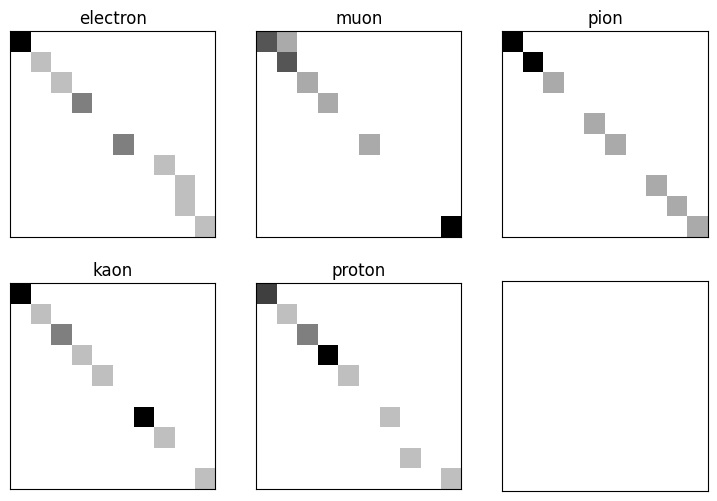

In [3]:
# Check for NaN values.
print(np.isnan(np.sum(data)))    # -> False

# Check range of values.
print(np.max(data), np.min(data))    # -> 8, 0

sleep(4)
clear_output()

# Get indexes for each different target possibility.
indexes = [
    np.where(target == 0)[0][0],
    np.where(target == 1)[0][0],
    np.where(target == 2)[0][0],
    np.where(target == 3)[0][0],
    np.where(target == 4)[0][0],
]

samples = [data[index] for index in indexes]
samples_target = [target_names[str(target[index])] for index in indexes]

fig, axs = plt.subplots(2, 3, figsize=(9, 6), subplot_kw={
    'yticks': (),
    'xticks': ()
})

axs = [ax for ax in axs.flatten()]

for sample, sample_target, ax in zip(samples, samples_target, axs):
    ax.imshow(sample, cmap='binary')
    ax.set_title(str(sample_target))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(data_sklearn, target, stratify=target)

y_train_sklearn, y_test_sklearn = ([], [])

for label in list(y_train):
    y_train_sklearn.append(list(label).index(1))    # changing sample from [0, 1, 0, 0, 0] to [2, .....]

for label in list(y_test):
    y_test_sklearn.append(list(label).index(1))

y_train_sklearn = np.array(y_train_sklearn)
y_test_sklearn = np.array(y_test_sklearn)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

print('\nsklearn versions')
print(f'X_train.shape: {X_train_sklearn.shape}')
print(f'y_train.shape: {y_train_sklearn.shape}')
print(f'X_test.shape: {X_test_sklearn.shape}')
print(f'y_test.shape: {y_test_sklearn.shape}')


#### Create TensorFlow Model

c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2443 - loss: 2.1393
Epoch 2/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3008 - loss: 2.0184
Epoch 3/3
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3356 - loss: 1.9661
Train accuracy: 36.8%
Test accuracy: 35.8%


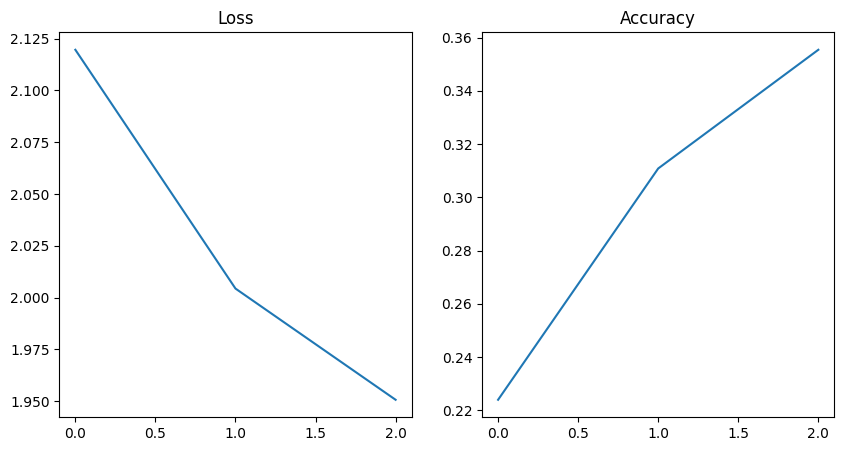

In [4]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(5, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

tf_model = Model()

tf_model.build(input_shape=(1, 10, 10, 1))
tf_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = tf_model.fit(X_train, y_train, epochs=3, batch_size=64).history

sleep(4)
# clear_output()

print(f'Train accuracy: {tf_model.evaluate(X_train, y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {tf_model.evaluate(X_test, y_test, verbose=False)[1]*100:.1f}%')

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(3), history['loss'])
ax_2.plot(range(3), history['accuracy'])

ax_1.set_title('Loss')
ax_2.set_title('Accuracy');


#### Re-iter Train and Test Accuracies 50 Times

In [5]:
results = [[], []]

for i in range(50):
    tf_model = Model()

    tf_model.build(input_shape=(1, 10, 10, 1))
    tf_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = tf_model.fit(X_train, y_train, epochs=3, batch_size=64,verbose=False).history
    train = tf_model.evaluate(X_train, y_train, verbose=False)[1]
    test = tf_model.evaluate(X_test, y_test, verbose=False)[1]

    results[0].append(train)
    results[1].append(test)

results = np.array(results)
results = np.transpose(results)
df = pd.DataFrame(results, columns=['train accuracy', 'test accuracy'])
df.to_csv('R Data Analysis/data/initial_accuracy.csv')

c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_3', however the layer does not 

#### Create `sklearn` Model

In [6]:
logreg = LogisticRegression()

logreg.fit(X_train_sklearn, y_train_sklearn)

print(f'Train Accuracy: {logreg.score(X_train_sklearn, y_train_sklearn)*100:.2f}%')
print(f'Test Accuracy: {logreg.score(X_test_sklearn, y_test_sklearn)*100:.2f}%')


Train Accuracy: 25.71%
Test Accuracy: 18.97%


c:\Users\chaga\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### More data analysis

In [7]:
def individual_particle_test(model):
    for i in range(5):
        int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
        particle_indexes = np.where(int_y_test == i)    # gives indexes for all electron, muon, etc testcases...

        X_test_modified = X_test[particle_indexes]
        y_test_modified = y_test[particle_indexes]

        print(f'{target_names[str(i)]} accuracy: {model.evaluate(X_test_modified, y_test_modified, verbose=False)[1]*100:.1f}%')

individual_particle_test(tf_model)


electron accuracy: 79.4%
muon accuracy: 47.4%
pion accuracy: 0.0%
kaon accuracy: 16.0%
proton accuracy: 12.0%


#### Test Results
<img src='images/test_1_(19).png'>
<img src='images/test 2 (19).png'></br>
difference between one test and another (inconsistencies)

#### Conclusion:
* The algorithm shows some promise for some particles, but little for others.
    * muon could have 100% accuracy because of its mass... has less quantum effect compared to others.
    * electron could be low because of quantum effects
    * proton is actually pretty consistent.
    * out of mesons, kaon and proton lowest while pion higher (because of higher mass than other mesons)
    * next steps, find reason for fluctuations in percentages and relationships between particles considering their properties.

#### Graph relationship between sample size and accuracy

In [8]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):
    
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)
    
        temp_tf_model = Model()
    
        temp_tf_model.build(input_shape=(1, 10, 10, 1))
        temp_tf_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        temp_tf_model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)
    
        initial_accuracy = temp_tf_model.evaluate(X_train, y_train, verbose=False)[1]
        
        if verbose:
            print(f'\nTrain accuracy: {initial_accuracy*100:.1f}% ({sample_number} samples)')
        
        if verbose:
            for re_iter in info_x_samples:
                data_new = re_iter[0]
                target_new = re_iter[1]
        
                scaler = StandardScaler()
        
                data_new = data_new.reshape(data_new.shape[0], -1)
                data_new = (scaler.fit_transform(data_new)).reshape((data_new.shape[0], 10, 10, 1))
        
                target_new = to_categorical(target_new)
        
                print(f'\t{(data_new.shape[0])/5} samples test: {tf_model.evaluate(data_new, target_new, verbose=False)[1]*100:.1f}%')
        
        results[-1].append(initial_accuracy)
    

samples_test()
for i in range(49):
    samples_test(verbose=False)


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_51', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 20.3% (50 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_52', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 26.1% (100 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_53', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 23.2% (150 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_54', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 18.5% (200 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_55', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 22.5% (250 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_56', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 24.1% (300 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_57', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 30.7% (350 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_58', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 24.3% (400 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_59', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 26.3% (450 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_60', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 19.0% (500 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_61', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 16.1% (550 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_62', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 43.4% (600 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_63', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 29.7% (650 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_64', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 31.3% (700 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 32.8%
	150.0 samples test: 30.5%
	200.0 samples test: 31.6%
	250.0 samples test: 31.8%
	300.0 samples test: 29.5%
	350.0 samples test: 31.5%
	400.0 samples test: 31.4%
	450.0 samples test: 31.5%
	500.0 samples test: 31.8%
	550.0 samples test: 31.7%
	600.0 samples test: 31.7%
	650.0 samples test: 31.4%
	700.0 samples test: 31.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_65', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_66', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_67', however the layer does n

#### Prepare results from tests for R data analysis

In [9]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/data/samples_test_data.csv')

#### 5 Test Runs (when trained on 700 samples):
<img src='images/accuracy_sample_test1.png'>
<img src='images/accuracy_sample_test2.png'>
<img src='images/accuracy_sample_test3.png'>
<img src='images/accuracy_sample_test4.png'>
<img src='images/accuracy_sample_test5.png'>

#### Additional test

In [10]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):
    
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)
    
        model = Model()
    
        model.build(input_shape=(1, 10, 10, 1))
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)
    
        initial_accuracy = model.evaluate(X_train, y_train, verbose=False)[1]
        
        if verbose:
            print(f'\nTrain accuracy: {initial_accuracy*100:.1f}% ({sample_number} samples)')
        
        if verbose:
            for re_iter in info_x_samples:
                data_new = re_iter[0]
                target_new = re_iter[1]
        
                scaler = StandardScaler()
        
                data_new = data_new.reshape(data_new.shape[0], -1)
                data_new = (scaler.fit_transform(data_new)).reshape((data_new.shape[0], 10, 10, 1))
        
                target_new = to_categorical(target_new)
        
                print(f'\t{(data_new.shape[0])/5} samples test: {model.evaluate(data_new, target_new, verbose=False)[1]*100:.1f}%')
        
        results[-1].append(initial_accuracy)


samples_test()
for i in range(49):
    samples_test(verbose=False)


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_751', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 17.6% (50 samples)
	50.0 samples test: 18.8%
	100.0 samples test: 17.4%
	150.0 samples test: 17.7%
	200.0 samples test: 17.2%
	250.0 samples test: 17.1%
	300.0 samples test: 17.3%
	350.0 samples test: 17.4%
	400.0 samples test: 17.5%
	450.0 samples test: 17.4%
	500.0 samples test: 17.2%
	550.0 samples test: 17.4%
	600.0 samples test: 17.3%
	650.0 samples test: 17.3%
	700.0 samples test: 17.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_752', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 25.6% (100 samples)
	50.0 samples test: 24.4%
	100.0 samples test: 25.8%
	150.0 samples test: 26.3%
	200.0 samples test: 26.3%
	250.0 samples test: 25.4%
	300.0 samples test: 25.9%
	350.0 samples test: 25.0%
	400.0 samples test: 25.2%
	450.0 samples test: 25.9%
	500.0 samples test: 25.9%
	550.0 samples test: 25.7%
	600.0 samples test: 26.3%
	650.0 samples test: 26.2%
	700.0 samples test: 25.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_753', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 27.0% (150 samples)
	50.0 samples test: 27.6%
	100.0 samples test: 29.4%
	150.0 samples test: 28.0%
	200.0 samples test: 27.6%
	250.0 samples test: 27.8%
	300.0 samples test: 27.3%
	350.0 samples test: 27.5%
	400.0 samples test: 27.6%
	450.0 samples test: 27.6%
	500.0 samples test: 27.3%
	550.0 samples test: 27.4%
	600.0 samples test: 27.4%
	650.0 samples test: 27.2%
	700.0 samples test: 27.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_754', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 19.4% (200 samples)
	50.0 samples test: 17.2%
	100.0 samples test: 19.2%
	150.0 samples test: 19.3%
	200.0 samples test: 18.6%
	250.0 samples test: 18.3%
	300.0 samples test: 18.5%
	350.0 samples test: 18.7%
	400.0 samples test: 18.9%
	450.0 samples test: 18.9%
	500.0 samples test: 19.2%
	550.0 samples test: 19.4%
	600.0 samples test: 19.3%
	650.0 samples test: 19.4%
	700.0 samples test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_755', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 27.7% (250 samples)
	50.0 samples test: 28.0%
	100.0 samples test: 28.0%
	150.0 samples test: 27.6%
	200.0 samples test: 27.4%
	250.0 samples test: 27.0%
	300.0 samples test: 27.6%
	350.0 samples test: 28.2%
	400.0 samples test: 28.0%
	450.0 samples test: 27.6%
	500.0 samples test: 27.5%
	550.0 samples test: 27.6%
	600.0 samples test: 27.7%
	650.0 samples test: 27.5%
	700.0 samples test: 27.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_756', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 27.5% (300 samples)
	50.0 samples test: 26.4%
	100.0 samples test: 29.8%
	150.0 samples test: 25.2%
	200.0 samples test: 25.8%
	250.0 samples test: 25.4%
	300.0 samples test: 25.3%
	350.0 samples test: 25.3%
	400.0 samples test: 25.7%
	450.0 samples test: 26.1%
	500.0 samples test: 26.0%
	550.0 samples test: 25.9%
	600.0 samples test: 25.5%
	650.0 samples test: 25.6%
	700.0 samples test: 25.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_757', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 30.7% (350 samples)
	50.0 samples test: 33.2%
	100.0 samples test: 32.4%
	150.0 samples test: 30.5%
	200.0 samples test: 29.1%
	250.0 samples test: 31.2%
	300.0 samples test: 30.8%
	350.0 samples test: 31.1%
	400.0 samples test: 30.6%
	450.0 samples test: 31.0%
	500.0 samples test: 31.1%
	550.0 samples test: 31.5%
	600.0 samples test: 31.6%
	650.0 samples test: 31.2%
	700.0 samples test: 31.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_758', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 22.2% (400 samples)
	50.0 samples test: 21.6%
	100.0 samples test: 23.0%
	150.0 samples test: 22.9%
	200.0 samples test: 22.7%
	250.0 samples test: 22.2%
	300.0 samples test: 21.9%
	350.0 samples test: 22.0%
	400.0 samples test: 22.1%
	450.0 samples test: 22.1%
	500.0 samples test: 21.6%
	550.0 samples test: 22.2%
	600.0 samples test: 22.3%
	650.0 samples test: 22.1%
	700.0 samples test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_759', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 31.2% (450 samples)
	50.0 samples test: 31.2%
	100.0 samples test: 30.0%
	150.0 samples test: 29.9%
	200.0 samples test: 29.3%
	250.0 samples test: 31.2%
	300.0 samples test: 31.5%
	350.0 samples test: 31.6%
	400.0 samples test: 31.5%
	450.0 samples test: 31.6%
	500.0 samples test: 31.4%
	550.0 samples test: 30.9%
	600.0 samples test: 30.9%
	650.0 samples test: 28.7%
	700.0 samples test: 30.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_760', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 27.5% (500 samples)
	50.0 samples test: 26.4%
	100.0 samples test: 28.2%
	150.0 samples test: 27.6%
	200.0 samples test: 29.2%
	250.0 samples test: 29.1%
	300.0 samples test: 28.5%
	350.0 samples test: 26.4%
	400.0 samples test: 26.5%
	450.0 samples test: 26.7%
	500.0 samples test: 27.0%
	550.0 samples test: 27.1%
	600.0 samples test: 27.2%
	650.0 samples test: 27.2%
	700.0 samples test: 27.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_761', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 34.1% (550 samples)
	50.0 samples test: 34.0%
	100.0 samples test: 33.8%
	150.0 samples test: 34.1%
	200.0 samples test: 34.3%
	250.0 samples test: 34.3%
	300.0 samples test: 33.7%
	350.0 samples test: 33.3%
	400.0 samples test: 32.9%
	450.0 samples test: 33.2%
	500.0 samples test: 33.9%
	550.0 samples test: 33.9%
	600.0 samples test: 34.0%
	650.0 samples test: 33.9%
	700.0 samples test: 33.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_762', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 38.8% (600 samples)
	50.0 samples test: 34.8%
	100.0 samples test: 33.2%
	150.0 samples test: 34.3%
	200.0 samples test: 36.4%
	250.0 samples test: 38.1%
	300.0 samples test: 38.3%
	350.0 samples test: 39.2%
	400.0 samples test: 38.8%
	450.0 samples test: 39.3%
	500.0 samples test: 39.2%
	550.0 samples test: 39.1%
	600.0 samples test: 38.9%
	650.0 samples test: 39.0%
	700.0 samples test: 39.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_763', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 41.8% (650 samples)
	50.0 samples test: 39.6%
	100.0 samples test: 40.6%
	150.0 samples test: 40.8%
	200.0 samples test: 41.2%
	250.0 samples test: 42.0%
	300.0 samples test: 41.6%
	350.0 samples test: 41.4%
	400.0 samples test: 41.0%
	450.0 samples test: 41.4%
	500.0 samples test: 41.9%
	550.0 samples test: 41.9%
	600.0 samples test: 42.0%
	650.0 samples test: 41.7%
	700.0 samples test: 41.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_764', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Train accuracy: 25.4% (700 samples)
	50.0 samples test: 26.8%
	100.0 samples test: 24.8%
	150.0 samples test: 26.1%
	200.0 samples test: 25.8%
	250.0 samples test: 24.9%
	300.0 samples test: 25.1%
	350.0 samples test: 25.4%
	400.0 samples test: 34.8%
	450.0 samples test: 34.7%
	500.0 samples test: 35.2%
	550.0 samples test: 35.1%
	600.0 samples test: 35.5%
	650.0 samples test: 35.4%
	700.0 samples test: 35.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_765', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_766', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_767', however the layer doe

#### New Test with Constant Test Samples (175 samples)

In [11]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]
sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test(verbose=True):

    dummy, static_X_test, dummy, static_y_test = train_test_split(data_700_samples, target_700_samples, stratify=target_700_samples)
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]
    
        scaler = StandardScaler()
    
        data_x_samples = data_x_samples.reshape(data_x_samples.shape[0], -1)
        data_x_samples = (scaler.fit_transform(data_x_samples)).reshape((data_x_samples.shape[0], 10, 10, 1))
        
        target_x_samples = to_categorical(target_x_samples)

        split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data_x_samples, target_x_samples, stratify=target_x_samples)
# TODO: why is the test accuracy different from the initial accuracy test?
        model = Model()
    
        model.build(input_shape=(1, 10, 10, 1))
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        
        model.fit(split_X_train, split_y_train, epochs=3, batch_size=64, verbose=False)
    
        train_accuracy = model.evaluate(split_X_train, split_y_train, verbose=False)[1]

        static_X_test = static_X_test.reshape(static_X_test.shape[0], -1)
        static_X_test = (scaler.transform(static_X_test)).reshape((static_X_test.shape[0], 10, 10, 1))

        test_accuracy = model.evaluate(static_X_test, to_categorical(static_y_test), verbose=False)[1]
        
        print(f'\t{(data_x_samples.shape[0])/5} samples train: {train_accuracy*100:.1f}% test: {test_accuracy*100:.1f}%')

        results[-1].append(test_accuracy)

for i in range(49):
    print(f"Run {i+1}")
    samples_test(verbose=False)
    print("\n")


Run 1


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1451', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 26.7% test: 32.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1452', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 8.5% test: 9.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1453', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.4% test: 14.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1454', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.9% test: 23.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1455', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 28.4% test: 26.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1456', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 17.7% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1457', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 33.7% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1458', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 20.3% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1459', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 24.6% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1460', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 30.2% test: 24.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1461', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 28.8% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1462', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 35.2% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1463', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 23.8% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1464', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 25.0% test: 20.3%


Run 2


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1465', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.4% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1466', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.7% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1467', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 26.7% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1468', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.3% test: 12.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1469', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 19.7% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1470', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 19.1% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1471', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 27.1% test: 22.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1472', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 32.5% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1473', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 39.1% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1474', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 22.3% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1475', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 38.6% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1476', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 22.4% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1477', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 32.0% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1478', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 35.1% test: 20.9%


Run 3


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1479', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 13.9% test: 13.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1480', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.1% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1481', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 23.3% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1482', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 22.9% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1483', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 24.5% test: 17.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1484', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 26.0% test: 24.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1485', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 27.9% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1486', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 27.7% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1487', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 33.4% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1488', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 33.2% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1489', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 37.2% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1490', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 19.9% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1491', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 33.6% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1492', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 21.4% test: 20.7%


Run 4


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1493', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 16.0% test: 16.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1494', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.3% test: 14.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1495', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 16.2% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1496', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.3% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1497', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 38.7% test: 17.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1498', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 18.9% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1499', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 20.2% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1500', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 33.1% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1501', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 34.1% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1502', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.7% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1503', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 42.2% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1504', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 22.8% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1505', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 37.9% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1506', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 36.3% test: 21.0%


Run 5


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1507', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 15.0% test: 15.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1508', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 22.1% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1509', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.2% test: 17.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1510', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 24.3% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1511', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 18.4% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1512', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 33.4% test: 22.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1513', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 19.1% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1514', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 18.3% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1515', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 17.8% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1516', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 20.8% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1517', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 38.1% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1518', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 18.2% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1519', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 27.1% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1520', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 39.2% test: 19.0%


Run 6


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1521', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.8% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1522', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.0% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1523', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.1% test: 17.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1524', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 13.7% test: 16.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1525', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 22.3% test: 16.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1526', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 18.5% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1527', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 33.2% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1528', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 24.1% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1529', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 29.6% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1530', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 26.2% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1531', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 27.3% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1532', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 32.3% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1533', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 21.5% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1534', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 26.2% test: 20.5%


Run 7


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1535', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.4% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1536', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.1% test: 14.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1537', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 20.8% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1538', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 29.6% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1539', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 17.4% test: 17.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1540', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 17.0% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1541', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 28.6% test: 23.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1542', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 33.5% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1543', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 17.7% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1544', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 23.5% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1545', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 34.1% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1546', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 30.7% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1547', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 34.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1548', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 23.1% test: 20.8%


Run 8


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1549', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 15.5% test: 17.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1550', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.3% test: 17.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1551', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 17.3% test: 25.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1552', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 22.3% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1553', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 18.8% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1554', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 34.0% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1555', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 22.9% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1556', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 22.2% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1557', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 39.4% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1558', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 28.9% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1559', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 20.3% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1560', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 23.4% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1561', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 18.8% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1562', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 28.8% test: 20.1%


Run 9


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1563', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.4% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1564', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 24.8% test: 24.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1565', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 30.4% test: 28.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1566', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 28.3% test: 22.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1567', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 27.6% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1568', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 16.1% test: 15.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1569', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 17.2% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1570', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 23.5% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1571', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 19.1% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1572', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.1% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1573', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 19.3% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1574', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 29.5% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1575', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 27.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1576', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 21.5% test: 20.0%


Run 10


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1577', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 15.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1578', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 26.9% test: 24.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1579', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 25.6% test: 29.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1580', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 18.4% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1581', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 22.1% test: 23.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1582', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 30.5% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1583', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 22.3% test: 25.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1584', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 24.3% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1585', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 28.6% test: 25.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1586', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 28.5% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1587', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 22.9% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1588', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 27.7% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1589', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 27.8% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1590', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 28.2% test: 20.0%


Run 11


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1591', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 22.5% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1592', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.9% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1593', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 19.4% test: 17.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1594', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 18.4% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1595', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 25.8% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1596', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 31.7% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1597', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 19.2% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1598', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 26.1% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1599', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 26.5% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1600', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 30.0% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1601', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 19.2% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1602', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 25.2% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1603', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 24.2% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1604', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 35.8% test: 20.0%


Run 12


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1605', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.9% test: 18.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1606', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.5% test: 23.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1607', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 27.4% test: 12.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1608', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 24.1% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1609', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 24.9% test: 27.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1610', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 22.4% test: 17.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1611', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 26.5% test: 16.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1612', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.3% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1613', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 24.7% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1614', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 37.6% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1615', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 33.6% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1616', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 37.3% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1617', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 32.1% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1618', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 36.0% test: 20.0%


Run 13


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1619', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 17.6% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1620', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 22.1% test: 26.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1621', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 17.4% test: 23.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1622', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.5% test: 25.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1623', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 23.6% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1624', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.6% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1625', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 20.4% test: 23.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1626', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 35.5% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1627', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 18.6% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1628', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 32.9% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1629', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 27.5% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1630', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1631', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 43.3% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1632', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 34.4% test: 21.0%


Run 14


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1633', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 14.4% test: 13.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1634', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 15.7% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1635', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.5% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1636', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.1% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1637', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 15.5% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1638', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 19.1% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1639', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 29.0% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1640', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.9% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1641', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 18.1% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1642', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 45.0% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1643', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 42.6% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1644', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 32.2% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1645', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 17.5% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1646', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 26.6% test: 20.7%


Run 15


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1647', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 18.7% test: 16.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1648', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 16.8% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1649', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 19.4% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1650', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 26.1% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1651', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 25.8% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1652', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 33.7% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1653', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 35.0% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1654', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 42.0% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1655', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 29.6% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1656', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 33.4% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1657', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 19.2% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1658', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.1% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1659', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 29.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1660', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 33.3% test: 20.6%


Run 16


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1661', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 27.8% test: 25.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1662', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 26.7% test: 24.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1663', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 20.5% test: 16.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1664', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 30.9% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1665', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 25.1% test: 16.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1666', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 17.2% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1667', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 32.3% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1668', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 21.9% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1669', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 34.1% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1670', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 23.7% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1671', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 31.7% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1672', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 34.8% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1673', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 28.4% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1674', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 26.7% test: 19.5%


Run 17


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1675', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1676', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.1% test: 23.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1677', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 19.6% test: 24.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1678', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 34.3% test: 24.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1679', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 17.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1680', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.4% test: 17.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1681', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 17.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1682', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 20.7% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1683', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 28.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1684', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 36.9% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1685', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 41.0% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1686', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.8% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1687', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 30.3% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1688', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 31.3% test: 19.8%


Run 18


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1689', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 24.6% test: 23.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1690', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.0% test: 23.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1691', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.0% test: 17.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1692', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.9% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1693', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 28.5% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1694', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.5% test: 22.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1695', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 29.2% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1696', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 22.7% test: 25.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1697', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 20.7% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1698', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 25.5% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1699', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 32.5% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1700', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 33.2% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1701', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 17.0% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1702', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 28.3% test: 19.2%


Run 19


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1703', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.9% test: 16.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1704', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.4% test: 23.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1705', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 26.5% test: 17.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1706', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.8% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1707', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 20.5% test: 23.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1708', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 29.4% test: 23.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1709', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 35.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1710', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 27.9% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1711', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 32.0% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1712', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 30.3% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1713', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 28.9% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1714', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 26.4% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1715', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 34.8% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1716', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 44.5% test: 19.7%


Run 20


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1717', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.8% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1718', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 19.5% test: 23.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1719', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 17.8% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1720', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 29.1% test: 28.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1721', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 23.8% test: 24.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1722', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 25.2% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1723', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 33.2% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1724', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.1% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1725', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 34.8% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1726', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 32.9% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1727', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 40.8% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1728', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 41.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1729', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 33.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1730', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 30.7% test: 19.5%


Run 21


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1731', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 24.6% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1732', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 32.5% test: 32.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1733', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.5% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1734', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 16.4% test: 31.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1735', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 21.5% test: 17.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1736', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 27.5% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1737', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 29.2% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1738', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 27.6% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1739', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 21.8% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1740', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.0% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1741', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 33.6% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1742', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 30.2% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1743', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 29.2% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1744', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 23.8% test: 19.7%


Run 22


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1745', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 14.4% test: 16.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1746', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.8% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1747', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.4% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1748', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 9.6% test: 22.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1749', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 31.5% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1750', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 22.8% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1751', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 29.7% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1752', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 24.5% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1753', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 23.2% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1754', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 21.6% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1755', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 31.0% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1756', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.2% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1757', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 31.2% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1758', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 21.9% test: 20.2%


Run 23


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1759', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 18.7% test: 24.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1760', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.1% test: 16.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1761', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 24.0% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1762', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 24.3% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1763', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 19.9% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1764', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 16.9% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1765', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 38.8% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1766', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 23.3% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1767', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 25.4% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1768', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.4% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1769', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 20.3% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1770', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 42.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1771', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 37.8% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1772', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 23.0% test: 21.9%


Run 24


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1773', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 16.0% test: 17.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1774', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.6% test: 11.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1775', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 22.4% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1776', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 19.6% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1777', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 20.0% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1778', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.0% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1779', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 21.5% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1780', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 18.5% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1781', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 27.9% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1782', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 30.8% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1783', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 29.6% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1784', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 40.6% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1785', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 36.7% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1786', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 29.3% test: 19.4%


Run 25


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1787', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.8% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1788', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 23.5% test: 24.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1789', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.0% test: 27.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1790', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.5% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1791', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 23.8% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1792', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.1% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1793', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 18.0% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1794', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 44.4% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1795', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 28.6% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1796', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 35.2% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1797', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 35.5% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1798', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 26.3% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1799', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 25.9% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1800', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 24.8% test: 21.6%


Run 26


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1801', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 27.8% test: 29.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1802', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 24.5% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1803', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.3% test: 28.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1804', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 18.3% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1805', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 20.4% test: 17.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1806', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 30.0% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1807', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 19.3% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1808', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.3% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1809', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 38.6% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1810', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 18.9% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1811', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 30.0% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1812', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 26.3% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1813', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 25.4% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1814', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 28.0% test: 19.3%


Run 27


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1815', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 24.6% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1816', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.1% test: 17.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1817', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.1% test: 22.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1818', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 23.6% test: 14.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1819', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 22.1% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1820', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 23.6% test: 25.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1821', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 32.0% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1822', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 30.9% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1823', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 35.9% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1824', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 22.2% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1825', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 39.3% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1826', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 21.2% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1827', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 29.4% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1828', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 23.4% test: 18.9%


Run 28


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1829', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 28.3% test: 28.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1830', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.5% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1831', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.5% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1832', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 27.5% test: 16.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1833', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 22.4% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1834', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.4% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1835', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 18.1% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1836', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 26.5% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1837', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 25.0% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1838', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 27.0% test: 22.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1839', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 32.6% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1840', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.2% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1841', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 26.7% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1842', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 31.5% test: 19.1%


Run 29


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1843', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.9% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1844', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 30.1% test: 14.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1845', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 27.6% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1846', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 25.9% test: 18.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1847', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 26.5% test: 24.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1848', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.6% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1849', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 26.0% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1850', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 37.6% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1851', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 27.0% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1852', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 33.8% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1853', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 37.2% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1854', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 32.0% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1855', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 36.3% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1856', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 28.3% test: 21.7%


Run 30


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1857', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.9% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1858', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.6% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1859', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 27.2% test: 16.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1860', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 22.0% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1861', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 24.5% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1862', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 16.2% test: 24.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1863', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 25.1% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1864', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 21.2% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1865', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 17.6% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1866', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 24.0% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1867', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 43.2% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1868', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 44.9% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1869', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 42.2% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1870', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 30.5% test: 19.5%


Run 31


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1871', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 21.4% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1872', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 18.7% test: 16.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1873', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 30.4% test: 15.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1874', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 18.3% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1875', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 26.8% test: 23.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1876', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 26.3% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1877', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 23.9% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1878', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 24.3% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1879', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 20.1% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1880', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 28.6% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1881', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 35.4% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1882', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 31.9% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1883', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 31.7% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1884', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 35.5% test: 20.1%


Run 32


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1885', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 25.1% test: 23.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1886', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 29.3% test: 13.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1887', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 24.4% test: 25.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1888', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 23.1% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1889', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 20.8% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1890', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 34.0% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1891', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 23.1% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1892', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 15.7% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1893', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 19.9% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1894', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 25.9% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1895', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 35.9% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1896', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 31.0% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1897', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 29.2% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1898', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 17.8% test: 19.2%


Run 33


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1899', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1900', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 19.5% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1901', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 35.8% test: 31.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1902', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 25.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1903', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 34.4% test: 17.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1904', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 27.4% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1905', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 30.9% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1906', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 23.1% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1907', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 29.3% test: 23.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1908', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 31.0% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1909', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 32.8% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1910', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 23.2% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1911', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 34.9% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1912', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 30.5% test: 20.3%


Run 34


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1913', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 22.5% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1914', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 22.9% test: 27.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1915', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 19.4% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1916', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 19.3% test: 22.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1917', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 26.3% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1918', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 22.7% test: 17.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1919', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 32.2% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1920', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 36.7% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1921', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 25.7% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1922', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.8% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1923', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 31.5% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1924', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 36.3% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1925', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 27.7% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1926', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 21.3% test: 19.9%


Run 35


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1927', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 24.6% test: 24.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1928', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 32.8% test: 23.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1929', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 22.2% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1930', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 19.2% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1931', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 19.4% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1932', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 18.5% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1933', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 13.4% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1934', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.1% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1935', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 30.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1936', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 25.0% test: 22.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1937', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 24.0% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1938', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 33.3% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1939', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 43.9% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1940', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 36.2% test: 20.9%


Run 36


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1941', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 12.8% test: 13.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1942', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.1% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1943', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 25.3% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1944', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 29.6% test: 15.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1945', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 30.2% test: 24.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1946', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 20.8% test: 25.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1947', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 23.3% test: 24.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1948', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 27.1% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1949', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 16.7% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1950', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 31.5% test: 23.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1951', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 18.5% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1952', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.2% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1953', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 37.1% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1954', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 31.8% test: 19.5%


Run 37


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1955', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 23.5% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1956', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 25.1% test: 24.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1957', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 25.8% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1958', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 29.6% test: 22.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1959', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 30.1% test: 11.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1960', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 35.6% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1961', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 23.5% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1962', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 25.1% test: 18.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1963', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 25.2% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1964', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 28.2% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1965', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 33.7% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1966', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 33.2% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1967', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 24.0% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1968', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 25.1% test: 19.7%


Run 38


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1969', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 18.2% test: 24.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1970', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 24.0% test: 18.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1971', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 17.8% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1972', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 23.2% test: 14.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1973', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 21.0% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1974', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 32.2% test: 26.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1975', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 23.7% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1976', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 23.3% test: 18.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1977', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 37.6% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1978', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 32.2% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1979', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 33.6% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1980', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 34.8% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1981', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 35.1% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1982', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 37.9% test: 21.5%


Run 39


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1983', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 16.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1984', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 12.5% test: 24.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1985', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 29.0% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1986', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 31.5% test: 26.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1987', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 28.3% test: 25.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1988', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 19.4% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1989', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 28.2% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1990', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 33.9% test: 24.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1991', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 19.6% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1992', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 19.6% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1993', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 23.9% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1994', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 17.7% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1995', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 26.3% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1996', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 36.5% test: 19.9%


Run 40


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1997', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.8% test: 20.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1998', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.1% test: 23.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_1999', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 24.9% test: 27.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2000', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 21.7% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2001', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 18.0% test: 20.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2002', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 22.2% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2003', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 36.0% test: 17.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2004', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 21.1% test: 22.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2005', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 22.1% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2006', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 32.9% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2007', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 28.3% test: 23.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2008', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 22.0% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2009', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 25.8% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2010', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 31.5% test: 19.9%


Run 41


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2011', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.8% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2012', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.6% test: 18.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2013', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 18.7% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2014', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 18.7% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2015', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 23.4% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2016', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 23.8% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2017', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 24.5% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2018', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.6% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2019', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 21.8% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2020', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 24.4% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2021', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 32.1% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2022', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 29.9% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2023', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 29.4% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2024', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 29.6% test: 20.0%


Run 42


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2025', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 17.6% test: 17.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2026', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 17.3% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2027', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.4% test: 17.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2028', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2029', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 17.3% test: 17.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2030', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 23.6% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2031', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 35.1% test: 26.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2032', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 39.5% test: 18.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2033', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 29.2% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2034', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 33.4% test: 18.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2035', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 17.1% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2036', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 31.7% test: 19.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2037', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 31.9% test: 20.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2038', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 26.7% test: 19.4%


Run 43


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2039', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 23.0% test: 23.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2040', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 27.5% test: 17.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2041', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.4% test: 25.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2042', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 22.0% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2043', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 24.8% test: 17.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2044', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 37.2% test: 24.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2045', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 15.5% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2046', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 33.1% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2047', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 20.2% test: 21.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2048', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 23.0% test: 19.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2049', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 37.1% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2050', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 32.7% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2051', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 26.6% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2052', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 32.4% test: 19.4%


Run 44


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2053', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 18.7% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2054', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 16.5% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2055', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 38.8% test: 22.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2056', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 24.8% test: 18.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2057', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 27.6% test: 24.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2058', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 25.2% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2059', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 24.6% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2060', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 36.7% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2061', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 28.6% test: 17.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2062', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 31.9% test: 23.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2063', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 30.4% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2064', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 30.0% test: 20.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2065', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 32.3% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2066', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 35.8% test: 19.3%


Run 45


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2067', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 18.7% test: 15.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2068', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.3% test: 21.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2069', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 14.4% test: 26.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2070', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.3% test: 19.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2071', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 26.0% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2072', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 31.6% test: 23.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2073', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 21.7% test: 23.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2074', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 32.3% test: 22.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2075', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 31.1% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2076', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 31.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2077', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 39.0% test: 22.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2078', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 25.2% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2079', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 35.7% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2080', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 25.1% test: 19.9%


Run 46


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2081', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 25.1% test: 25.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2082', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 14.1% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2083', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 21.9% test: 22.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2084', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 20.3% test: 16.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2085', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 18.4% test: 23.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2086', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 21.5% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2087', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 20.6% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2088', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 19.5% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2089', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 21.3% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2090', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 28.2% test: 23.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2091', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 20.2% test: 20.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2092', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 31.4% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2093', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 19.5% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2094', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 20.9% test: 21.4%


Run 47


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2095', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 19.3% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2096', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 21.9% test: 15.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2097', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 24.9% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2098', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 23.2% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2099', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 20.6% test: 21.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2100', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 35.0% test: 21.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2101', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 19.6% test: 22.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2102', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 40.5% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2103', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 21.9% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2104', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 24.5% test: 17.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2105', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 28.4% test: 22.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2106', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 28.5% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2107', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 33.5% test: 20.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2108', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 19.4% test: 21.6%


Run 48


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2109', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2110', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 25.1% test: 21.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2111', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 27.6% test: 17.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2112', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 23.6% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2113', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 35.2% test: 19.8%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2114', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 21.7% test: 25.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2115', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 33.1% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2116', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 24.6% test: 23.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2117', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 17.0% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2118', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 18.2% test: 20.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2119', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 30.8% test: 21.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2120', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 37.2% test: 19.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2121', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 25.0% test: 19.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2122', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 45.1% test: 21.6%


Run 49


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2123', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	50.0 samples train: 20.3% test: 21.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2124', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	100.0 samples train: 20.3% test: 18.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2125', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	150.0 samples train: 26.2% test: 22.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2126', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	200.0 samples train: 17.5% test: 18.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2127', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	250.0 samples train: 23.7% test: 19.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2128', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	300.0 samples train: 23.6% test: 15.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2129', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	350.0 samples train: 22.3% test: 19.4%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2130', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	400.0 samples train: 20.8% test: 23.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2131', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	450.0 samples train: 29.6% test: 20.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2132', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	500.0 samples train: 14.1% test: 20.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2133', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	550.0 samples train: 29.3% test: 19.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2134', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	600.0 samples train: 34.7% test: 21.1%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2135', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	650.0 samples train: 32.9% test: 21.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2136', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


	700.0 samples train: 33.5% test: 19.1%




#### Prepare CSV for R Data Analysis

In [12]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/data/samples_test_175_data.csv')

## Total dataset test

#### Setup data

In [13]:
# In this test, we evaluate the models accuracies on the dataset without limit of 700 per class.
# However, first we must setup the data, as shown in the top of the notebook.

data_total = []
target_total = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file = pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data_total.append(sample)
        target_total.append(sample_target)

data_total = np.array(data_total)
target_total = np.array(target_total)

sleep(7)
clear_output()

print(f'original data.shape: {data_total.shape}')
print(f'original target.shape: {target_total.shape}\n')

# Edit target values to 0, 1, 2...
new_target = []

for tar in target_total:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target_total = np.array(new_target)

for i in range(5):
    particle_indexes = np.where(target_total == i)[0]

    data_modified = data_total[particle_indexes]
    target_modified = target_total[particle_indexes]
    
    print(f'{target_names[str(i)]}.shape: {data_modified.shape}, {target_modified.shape}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_total, target_total, stratify=target_total)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'\nX_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

# NOTE: We are using the unbalanced dataset in order to see if there is correlation to high accuracy with particles that have high # of samples.
#       Based on the dataset partitions below, we would expect pion, kaon, and proton to have a higher accuracy.

original data.shape: (1259300, 10, 10)
original target.shape: (1259300,)

electron.shape: (3150, 10, 10), (3150,)
muon.shape: (700, 10, 10), (700,)
pion.shape: (981050, 10, 10), (981050,)
kaon.shape: (160300, 10, 10), (160300,)
proton.shape: (114100, 10, 10), (114100,)

X_train.shape: (944475, 10, 10, 1)
y_train.shape: (944475, 5)
X_test.shape: (314825, 10, 10, 1)
y_test.shape: (314825, 5)


#### Prepare test

In [14]:
results = []

def individual_particle_test_modified(model):    # The only difference with this one is we record the data

    results.append([])
    model_recreate = Model()

    model_recreate.build(input_shape=(1, 10, 10, 1))
    model_recreate.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model_recreate.fit(X_train, y_train, epochs=3, batch_size=64, verbose=False).history    # We want to recreate the model every run so that we get different results

    for i in range(5):
        int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
        particle_indexes = np.where(int_y_test == i)    # gives indexes for all electron, muon, etc testcases...

        X_test_modified = X_test[particle_indexes]
        y_test_modified = y_test[particle_indexes]

        particle_accuracy = model_recreate.evaluate(X_test_modified, y_test_modified, verbose=False)[1]

        print(f'{target_names[str(i)]} accuracy: {particle_accuracy*100:.1f}%')

        results[-1].append(particle_accuracy)

for i in range(50):
    individual_particle_test_modified(tf_model)

# Basically, in this test, train on ENTIRE dataset;
# test on specific particle (recorded as result)

c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2137', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2138', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2139', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2140', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.7%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2141', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.7%
proton accuracy: 1.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2142', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2143', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.8%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2144', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2145', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 2.2%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2146', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.9%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2147', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2148', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2149', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2150', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2151', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.8%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2152', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.8%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2153', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2154', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2155', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2156', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2157', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2158', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.6%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2159', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2160', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2161', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2162', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2163', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2164', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2165', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2166', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2167', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.9%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2168', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.9%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2169', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2170', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 1.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2171', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2172', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.9%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2173', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 0.8%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2174', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 1.2%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2175', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2176', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2177', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2178', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.3%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2179', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.5%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2180', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2181', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2182', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2183', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.3%
proton accuracy: 0.7%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2184', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.5%
proton accuracy: 1.0%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2185', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.9%
proton accuracy: 0.6%


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'model_2186', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


electron accuracy: 0.0%
muon accuracy: 0.0%
pion accuracy: 100.0%
kaon accuracy: 1.1%
proton accuracy: 1.0%


#### Prepare results for R data analysis

In [15]:
results = np.array(results)
df = pd.DataFrame(results, columns=['electron accuracy', 'muon accuracy', 'pion accuracy', 'kaon accuracy', 'proton accuracy'])
df.to_csv('R Data Analysis/data/total_dataset_test_data.csv')

## Muon vs All Test

In [17]:
# In this test, we change the target where the muon is 1 and all else is changed to 0.

muon_data, muon_target = (data_700_samples, target_700_samples)

muon_target = list(muon_target)

# muon before is label 1 (already), everything else needs to be changed to a 0
for i in range(len(muon_target)):
    if muon_target[i] != 1:
        muon_target[i] = 0

muon_target = np.array(muon_target)

# change dataset to 700 muon and 700 other
muon_indexes = np.where(muon_target == 1)
other_indexes = np.where(muon_target == 0)

muon_target = np.append(muon_target[muon_indexes], muon_target[other_indexes][:700])
muon_data = np.append(muon_data[muon_indexes], muon_data[other_indexes][:700], axis=0)

# muon_data = muon_data.reshape(muon_data.shape[0], -1)
# muon_data = (scaler.fit_transform(muon_data)).reshape(muon_data.shape[0], 10, 10, 1)

print(muon_data.shape)
print(muon_target.shape)


(1400, 10, 10)
(1400,)


In [18]:
muon_X_train, muon_X_test, muon_y_train, muon_y_test = train_test_split(muon_data, muon_target, test_size=100, stratify=muon_target)

scaler = StandardScaler()

muon_X_train = muon_X_train.reshape(muon_X_train.shape[0], -1)
muon_X_test = muon_X_test.reshape(muon_X_test.shape[0], -1)

muon_X_train = (scaler.fit_transform(muon_X_train)).reshape((muon_X_train.shape[0], 10, 10, 1))
muon_X_test = (scaler.transform(muon_X_test)).reshape((muon_X_test.shape[0], 10, 10, 1))

muon_y_test = to_categorical(muon_y_test)
muon_y_train = to_categorical(muon_y_train)

# muon_X_train, muon_y_train = (np.append(muon_data[:350], muon_data[700:1050], axis=0), np.append(muon_target[:350], muon_target[700:1050]))
# muon_X_test, muon_y_test = (np.append(muon_data[350:700], muon_data[1050:1400], axis=0), np.append(muon_target[350:700], muon_target[1050:1400]))

# moun_target = to_categorical(muon_target)

class Muon_Model(tf.keras.Model):
    def __init__(self):
        super(Muon_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(2, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)


muon_model = Muon_Model()

muon_model.build(input_shape=(1, 10, 10, 1))
muon_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = muon_model.fit(muon_X_train, muon_y_train, epochs=7, batch_size=64, verbose=False)

train_accuracy_muon = muon_model.evaluate(muon_X_train, muon_y_train, verbose=False)[1]
test_accuracy_muon = muon_model.evaluate(muon_X_test, muon_y_test, verbose=False)[1]

print(f'Train accuracy: {train_accuracy_muon}')
print(f'Test accuracy: {test_accuracy_muon}\n')


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'muon__model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Train accuracy: 0.8899999856948853
Test accuracy: 0.8799999952316284



#### Muon Test: Confusion Matrix

In [19]:
predictions = muon_model.predict(muon_X_test)
predictions_stable = []

for prediction in predictions:
    predictions_stable.append(np.argmax(prediction))

answers = muon_y_test
answers_stable = []

for answer in answers:
    answers_stable.append(np.argmax(answer))

print(confusion_matrix(np.array(answers_stable), np.array(predictions_stable)))

# Remember, 0 is everything else, 1 is muon

print(f'TP Rate 100%')    # 100% on predicting samples labeled 1
print(f'FP Rate 100%')    # 100% on predicting samples labeled 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[38 12]
 [ 0 50]]
TP Rate 100%
FP Rate 100%


## Electron vs Non-Electron

In [20]:
# In this test, we change the target where the electron is 1 and all else is changed to 0.

electron_data, electron_target = (data_700_samples, target_700_samples)

electron_target = list(electron_target)

# electron is label 0 (change to 1), everything else becomes 0. 
for i in range(len(electron_target)):
    if electron_target[i] != 0:
        electron_target[i] = 0
    else:
        electron_target[i] = 1 

electron_target = np.array(electron_target)        

# change dataset to 700 electron and 700 other
electron_indexes = np.where(electron_target == 1)
other_indexes = np.where(electron_target == 0)

electron_target = np.append(electron_target[electron_indexes], electron_target[other_indexes][:700])
electron_data = np.append(electron_data[electron_indexes], electron_data[other_indexes][:700], axis=0)

print(electron_data.shape)
print(electron_target.shape)


(1400, 10, 10)
(1400,)


In [21]:
electron_X_train, electron_X_test, electron_y_train, electron_y_test = train_test_split(electron_data, electron_target, test_size = 100, stratify = electron_target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
electron_X_train = electron_X_train.reshape(electron_X_train.shape[0], -1)
electron_X_test = electron_X_test.reshape(electron_X_test.shape[0], -1)

# Scale and reshape data back to og form.
electron_X_train = (scaler.fit_transform(electron_X_train)).reshape((electron_X_train.shape[0], 10, 10, 1))
electron_X_test = (scaler.transform(electron_X_test)).reshape((electron_X_test.shape[0], 10, 10, 1))

electron_y_test = to_categorical(electron_y_test)
electron_y_train = to_categorical(electron_y_train)

print(f'X_train.shape: {electron_X_train.shape}')
print(f'y_train.shape: {electron_y_train.shape}')
print(f'X_test.shape: {electron_X_test.shape}')
print(f'y_test.shape: {electron_y_test.shape}')

X_train.shape: (1300, 10, 10, 1)
y_train.shape: (1300, 2)
X_test.shape: (100, 10, 10, 1)
y_test.shape: (100, 2)


In [22]:

class Electron_Model(tf.keras.Model):
    def __init__(self):
        super(Electron_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(2, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

electron_model = Electron_Model()

electron_model.build(input_shape=(1, 10, 10, 1))
electron_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = electron_model.fit(electron_X_train, electron_y_train, epochs=7, batch_size=64, verbose=False)

sleep(4)

print(f'Train accuracy: {electron_model.evaluate(electron_X_train, electron_y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {electron_model.evaluate(electron_X_test, electron_y_test, verbose=False)[1]*100:.1f}%')


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'electron__model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Train accuracy: 75.6%
Test accuracy: 67.0%


#### Electron Test: Confusion Matrix

In [23]:
predictions = electron_model.predict(electron_X_test)
predictions_stable = []

for prediction in predictions:
    predictions_stable.append(np.argmax(prediction))

answers = electron_y_test
answers_stable = []

for answer in answers:
    answers_stable.append(np.argmax(answer))

print(confusion_matrix(np.array(answers_stable), np.array(predictions_stable)))

# Remember, 0 is everything else, 1 is electron

# Remember, 0 is electron, 1 is everything else

print(f'TP Rate 100%')    # 50% on predicting samples labeled 1
print(f'FP Rate 100%')    # 100% on predicting samples labeled 0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[17 33]
 [ 0 50]]
TP Rate 100%
FP Rate 100%


## Pion vs Non-Pion

In [24]:
# In this test, we change the target where the pion is 0 and all else is changed to 1.

pion_data, pion_target = (data_700_samples, target_700_samples)

pion_target = list(pion_target)

# pion is label 2 (change to 1), everything else needs to be changed to a 0
for i in range(len(pion_target)):
    if pion_target[i] != 2:
        pion_target[i] = 0
    else:
        pion_target[i] = 1

pion_target = np.array(pion_target)        

# change dataset to 700 pion and 700 other
pion_indexes = np.where(pion_target == 1)
other_indexes = np.where(pion_target == 0)

pion_target = np.append(pion_target[pion_indexes], pion_target[other_indexes][:700])
pion_data = np.append(pion_data[pion_indexes], pion_data[other_indexes][:700], axis=0)

print(pion_data.shape)
print(pion_target.shape)


(1400, 10, 10)
(1400,)


In [25]:
pion_X_train, pion_X_test, pion_y_train, pion_y_test = train_test_split(pion_data, pion_target, test_size = 100, stratify = pion_target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
pion_X_train = pion_X_train.reshape(pion_X_train.shape[0], -1)
pion_X_test = pion_X_test.reshape(pion_X_test.shape[0], -1)

# Scale and reshape data back to og form.
pion_X_train = (scaler.fit_transform(pion_X_train)).reshape((pion_X_train.shape[0], 10, 10, 1))
pion_X_test = (scaler.transform(pion_X_test)).reshape((pion_X_test.shape[0], 10, 10, 1))

pion_y_test = to_categorical(pion_y_test)
pion_y_train = to_categorical(pion_y_train)

print(f'X_train.shape: {pion_X_train.shape}')
print(f'y_train.shape: {pion_y_train.shape}')
print(f'X_test.shape: {pion_X_test.shape}')
print(f'y_test.shape: {pion_y_test.shape}')


X_train.shape: (1300, 10, 10, 1)
y_train.shape: (1300, 2)
X_test.shape: (100, 10, 10, 1)
y_test.shape: (100, 2)


In [26]:
class Pion_Model(tf.keras.Model):
    def __init__(self):
        super(Pion_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(2, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

pion_model = Pion_Model()

pion_model.build(input_shape=(1, 10, 10, 1))
pion_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = pion_model.fit(pion_X_train, pion_y_train, epochs=7, batch_size=64, verbose=False)

sleep(4)

print(f'Train accuracy: {pion_model.evaluate(pion_X_train, pion_y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {pion_model.evaluate(pion_X_test, pion_y_test, verbose=False)[1]*100:.1f}%')

c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'pion__model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Train accuracy: 90.2%
Test accuracy: 95.0%


#### Pion Test: Confusion Matrix

In [27]:
predictions = pion_model.predict(pion_X_test)
predictions_stable = []

for prediction in predictions:
    predictions_stable.append(np.argmax(prediction))

answers = pion_y_test
answers_stable = []

for answer in answers:
    answers_stable.append(np.argmax(answer))

print(confusion_matrix(np.array(answers_stable), np.array(predictions_stable)))

# Remember, 1 is pion, 0 is everything else.

print(f'TP Rate 64.5%')    # 50% on predicting samples labeled 1 TODO: fix these
print(f'FP Rate 96%')    # 0% on predicting smaples labeled 0


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000025340A90DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[50  0]
 [ 5 45]]
TP Rate 64.5%
FP Rate 96%


## Kaon vs Non-Kaon

In [28]:
# In this test, we change the target where the kaon is 1 and all else is changed to 0.

kaon_data, kaon_target = (data_700_samples, target_700_samples)

kaon_target = list(kaon_target)

# kaon is label 3 (make 1), everything else needs to be changed to a 0.
for i in range(len(kaon_target)):
    if kaon_target[i] != 3:
        kaon_target[i] = 0
    else:
        kaon_target[i] = 1

kaon_target = np.array(kaon_target)        

# change dataset to 700 kaon and 700 other
kaon_indexes = np.where(kaon_target == 1)
other_indexes = np.where(kaon_target == 0)

kaon_target = np.append(kaon_target[kaon_indexes], kaon_target[other_indexes][:700])
kaon_data = np.append(kaon_data[kaon_indexes], kaon_data[other_indexes][:700], axis=0)

print(kaon_data.shape)
print(kaon_target.shape)


(1400, 10, 10)
(1400,)


In [29]:
kaon_X_train, kaon_X_test, kaon_y_train, kaon_y_test = train_test_split(kaon_data, kaon_target, test_size = 100, stratify = kaon_target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
kaon_X_train = kaon_X_train.reshape(kaon_X_train.shape[0], -1)
kaon_X_test = kaon_X_test.reshape(kaon_X_test.shape[0], -1)

# Scale and reshape data back to og form.
kaon_X_train = (scaler.fit_transform(kaon_X_train)).reshape((kaon_X_train.shape[0], 10, 10, 1))
kaon_X_test = (scaler.transform(kaon_X_test)).reshape((kaon_X_test.shape[0], 10, 10, 1))

kaon_y_test = to_categorical(kaon_y_test)
kaon_y_train = to_categorical(kaon_y_train)

print(f'X_train.shape: {kaon_X_train.shape}')
print(f'y_train.shape: {kaon_y_train.shape}')
print(f'X_test.shape: {kaon_X_test.shape}')
print(f'y_test.shape: {kaon_y_test.shape}')


X_train.shape: (1300, 10, 10, 1)
y_train.shape: (1300, 2)
X_test.shape: (100, 10, 10, 1)
y_test.shape: (100, 2)


In [30]:
class Kaon_Model(tf.keras.Model):
    def __init__(self):
        super(Kaon_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(2, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

kaon_model = Kaon_Model()

kaon_model.build(input_shape=(1, 10, 10, 1))
kaon_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = kaon_model.fit(kaon_X_train, kaon_y_train, epochs=7, batch_size=64, verbose=False)

sleep(4)

print(f'Train accuracy: {kaon_model.evaluate(kaon_X_train, kaon_y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {kaon_model.evaluate(kaon_X_test, kaon_y_test, verbose=False)[1]*100:.1f}%')


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'kaon__model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Train accuracy: 91.9%
Test accuracy: 87.0%


#### Kaon Test: Confusion Matrix

In [31]:
predictions = kaon_model.predict(kaon_X_test)
predictions_stable = []

for prediction in predictions:
    predictions_stable.append(np.argmax(prediction))

answers = kaon_y_test
answers_stable = []

for answer in answers:
    answers_stable.append(np.argmax(answer))

print(confusion_matrix(np.array(answers_stable), np.array(predictions_stable)))

# Remember, 0 is everything else, 1 is kaon

print(f'TP Rate 100%')    # 50% on predicting samples labeled 1 TODO: fix this
print(f'FP Rate 90.9%')    # 0% on predicting samples labeled 0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[50  0]
 [13 37]]
TP Rate 100%
FP Rate 90.9%


## Proton vs Non-Proton

In [32]:
# In this test, we change the target where the proton is 1 and all else is changed to 0.

proton_data, proton_target = (data_700_samples, target_700_samples)

proton_target = list(proton_target)

# proton is label 4 (change to 1), everything else needs to be changed to a 0
for i in range(len(proton_target)):
    if proton_target[i] != 4:
        proton_target[i] = 0
    else:
        proton_target[i] = 1

proton_target = np.array(proton_target)        

# change dataset to 700 proton and 700 other
proton_indexes = np.where(proton_target == 1)
other_indexes = np.where(proton_target == 0)

proton_target = np.append(proton_target[proton_indexes], proton_target[other_indexes][:700])
proton_data = np.append(proton_data[proton_indexes], proton_data[other_indexes][:700], axis=0)

print(proton_data.shape)
print(proton_target.shape)

(1400, 10, 10)
(1400,)


In [33]:
proton_X_train, proton_X_test, proton_y_train, proton_y_test = train_test_split(proton_data, proton_target, test_size = 100, stratify = proton_target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
proton_X_train = proton_X_train.reshape(proton_X_train.shape[0], -1)
proton_X_test = proton_X_test.reshape(proton_X_test.shape[0], -1)

# Scale and reshape data back to og form.
proton_X_train = (scaler.fit_transform(proton_X_train)).reshape((proton_X_train.shape[0], 10, 10, 1))
proton_X_test = (scaler.transform(proton_X_test)).reshape((proton_X_test.shape[0], 10, 10, 1))

proton_y_test = to_categorical(proton_y_test)
proton_y_train = to_categorical(proton_y_train)

print(f'X_train.shape: {proton_X_train.shape}')
print(f'y_train.shape: {proton_y_train.shape}')
print(f'X_test.shape: {proton_X_test.shape}')
print(f'y_test.shape: {proton_y_test.shape}')

X_train.shape: (1300, 10, 10, 1)
y_train.shape: (1300, 2)
X_test.shape: (100, 10, 10, 1)
y_test.shape: (100, 2)


In [34]:
class Proton_Model(tf.keras.Model):
    def __init__(self):
        super(Proton_Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(2, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

proton_model = Proton_Model()

proton_model.build(input_shape=(1, 10, 10, 1))
proton_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = proton_model.fit(proton_X_train, proton_y_train, epochs=7, batch_size=64, verbose=False)

sleep(4)

print(f'Train accuracy: {proton_model.evaluate(proton_X_train, proton_y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {proton_model.evaluate(proton_X_test, proton_y_test, verbose=False)[1]*100:.1f}%')


c:\Users\chaga\miniconda3\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'proton__model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Train accuracy: 86.0%
Test accuracy: 87.0%


#### Proton Test: Confusion Matrix

In [37]:
predictions = proton_model.predict(proton_X_test)
predictions_stable = []

for prediction in predictions:
    predictions_stable.append(np.argmax(prediction))

answers = proton_y_test
answers_stable = []

for answer in answers:
    answers_stable.append(np.argmax(answer))

print(confusion_matrix(np.array(answers_stable), np.array(predictions_stable)))

# Remember, 0 is everything else, 1 is proton

print(f'TP Rate 63.3%')    # 50% on predicting samples labeled 1
print(f'FP Rate 70%')    # 0% on predicting samples labeled 0 TODO: fix this


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
[[50  0]
 [13 37]]
TP Rate 63.3%
FP Rate 70%
